## Model Selection & Implementation Strategy

### Extreme Class Imbalance

The primary challenge of this dataset is the extreme scarcity of the target class (Fraud). With fraud representing only 0.17% of all transactions, standard models would likely achieve 99.9% accuracy simply by predicting "Not Fraud" every time. To solve this, we require models that can prioritize the minority class and a training strategy (SMOTE) that balances the data without leaking information into our test set.

### Model Selection

We selected three distinct architectures to evaluate different mathematical approaches to fraud detection:

- `LightGBM`: Chosen for its efficiency and specialized handling of imbalanced data through the **`class_weight`** parameter. It is often the fastest to train on large datasets.

- `XGBoost`: The industry standard for tabular data. It is highly robust against outliers and provides superior control over the "Recall vs. Precision" tradeoff via the **`scale_pos_weight`** parameter.

- `Neural Network`: A Multi-Layer Perceptron was included to capture non-linear, deep-seated relationships between the PCA-transformed features ($V1-V28$) that tree-based models might miss.

### Hyperparameter Tuning & Configuration

We utilize `GridSearchCV` to systematically test various parameter combinations across a 3-fold cross-validation strategy. This ensures that we identify the optimal configuration for each model, specifically targeting the best F1-Score to balance the detection of fraudulent transactions with the reduction of false alarms.

| Model | Key Parameters Adjusted | Purpose |
|------|-------------------------|---------|
| **LightGBM** | `n_estimators`, `learning_rate`, `num_leaves` | To balance model complexity and learning speed while avoiding overfitting. |
| **XGBoost** | `max_depth`, `scale_pos_weight` | To control tree depth and give more importance to the minority class (Fraud). |
| **Neural Network** | `hidden_layer_sizes`, `alpha` | To optimize network depth and apply L2 regularization for better generalization. |

In [23]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score, classification_report, precision_recall_curve, ConfusionMatrixDisplay, auc
import matplotlib.pyplot as plt

X_train = pd.read_csv('X_train_final.csv')
X_test = pd.read_csv('X_test_final.csv')
y_train = pd.read_csv('y_train_final.csv').values.ravel()
y_test = pd.read_csv('y_test_final.csv').values.ravel()

models_config = [
    {
        'name': 'LightGBM',
        'model': lgb.LGBMClassifier(random_state=42, verbosity=-1),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__num_leaves': [31, 50],
            'classifier__class_weight': ['balanced']
        }
    },
    {
        'name': 'XGBoost',
        'model': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [3, 6],
            'classifier__learning_rate': [0.1],
            'classifier__scale_pos_weight': [1, 10]
        }
    },
    {
        'name': 'Neural Network',
        'model': MLPClassifier(random_state=42, max_iter=500),
        'params': {
            'classifier__hidden_layer_sizes': [(50,), (100, 50)],
            'classifier__alpha': [0.001, 0.01],
            'classifier__activation': ['relu']
        }
    }
]

### Training Strategy: SMOTE Pipeline

To address the extreme class imbalance without causing Data Leakage, we utilize an `imblearn` Pipeline. This ensures that:

- SMOTE (Synthetic Minority Over-sampling Technique) is applied only to the training folds during cross-validation.

- The model is evaluated on "unseen" imbalanced data that reflects the real-world distribution.

- The search is optimized for the F1-Score, which provides a better balance between Precision and Recall than standard Accuracy.



In [24]:
results = []
curves = {}
y_preds_list = []

for config in models_config:
    print(f"--- Processing: {config['name']} ---")
    
    pipeline = imbpipeline(steps=[
        ('smote', SMOTE(random_state=42)),
        ('classifier', config['model'])
    ])
    
    grid = GridSearchCV(pipeline, config['params'], cv=3, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_preds_list.append(y_pred)

    if hasattr(best_model, "predict_proba"):
        y_probs = best_model.predict_proba(X_test)[:, 1]
    else:
        y_probs = best_model.decision_function(X_test)

    prec_coords, rec_coords, _ = precision_recall_curve(y_test, y_probs)
    curves[config['name']] = (prec_coords, rec_coords)

    results.append({
        'Model': config['name'],
        'F1-Score': f1_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'AUPRC': average_precision_score(y_test, y_probs)
    })


results_df = pd.DataFrame(results).sort_values(by='AUPRC', ascending=False)
display(results_df)

--- Processing: LightGBM ---
--- Processing: XGBoost ---
--- Processing: Neural Network ---


,Model,F1-Score,Recall,Precision,AUPRC
1,XGBoost,0.785714,0.810526,0.762376,0.821539
0,LightGBM,0.802083,0.810526,0.793814,0.788368
2,Neural Network,0.755319,0.747368,0.763441,0.777931


### Comparison Results

The following plot compares the three architectures based on their ability to maintain high precision as we increase the recall threshold. Based on the generated curves:

- **`XGBoost`** achieved the highest **AUPRC (0.821)**, showing the most stable performance across different thresholds.

- **`LightGBM (0.788)`** performed well but showed early instability in precision.

- **`The Neural Network (0.778)`** captured complex patterns but lost precision more rapidly than the tree-based ensembles after 75% recall.

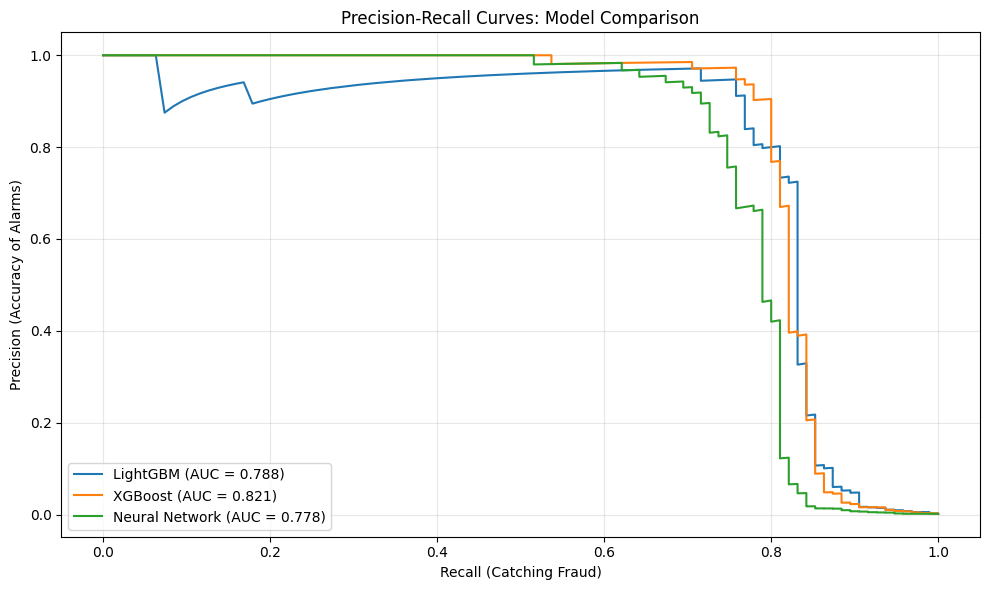

In [20]:
plt.figure(figsize=(10, 6))

for name, (prec, rec) in curves.items():
    pr_auc = auc(rec, prec)
    plt.plot(rec, prec, label=f"{name} (AUC = {pr_auc:.3f})")

plt.xlabel('Recall (Catching Fraud)')
plt.ylabel('Precision (Accuracy of Alarms)')
plt.title('Precision-Recall Curves: Model Comparison')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Comparative Analysis

By plotting the confusion matrices side-by-side, we can observe how each architecture prioritizes different types of errors:

| Metric | LightGBM | XGBoost | Neural Network |
|------|---------|---------|----------------------|
| **AUPRC (Primary Metric)** | 0.788 | **0.821 (Best)** | 0.778 |
| **True Positives (Caught Fraud)** | 77 | 77 | 71 |
| **False Negatives (Missed Fraud)** | 18 | 18 | 24 |
| **False Positives (False Alarms)** | **20 (Lowest)** | 24 | 22 

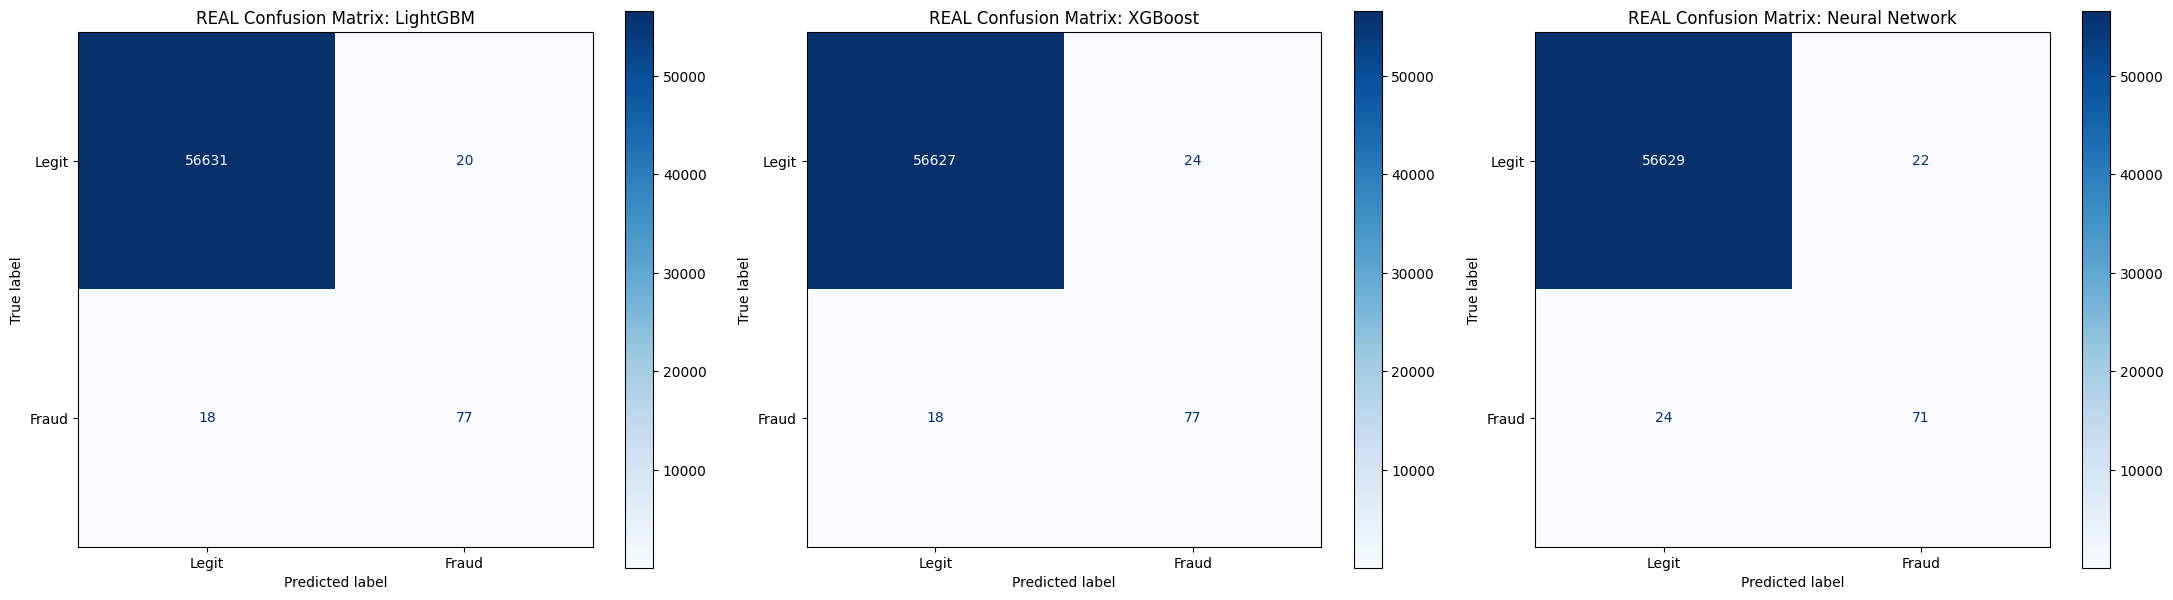

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

for i, config in enumerate(models_config):
    ConfusionMatrixDisplay.from_predictions(
        y_test, 
        y_preds_list[i], 
        display_labels=['Legit', 'Fraud'],
        cmap='Blues',
        ax=axes[i],
        values_format='d'
    )
    axes[i].set_title(f"REAL Confusion Matrix: {config['name']}")

plt.tight_layout()
plt.show()

### Model Interpretation and Feature Analysis

After identifying **XGBoost** as a top-performing model, we perform a deep dive into its decision-making process. This step is crucial for fraud detection to ensure the model is focusing on relevant patterns rather than noise.

#### Global Feature Importance (Gain)
We first examine the built-in feature importance. This measures the **Gain**, which represents the relative contribution of each feature to the model by calculating each feature's contribution to each tree in the model.

- **Objective**: Identify which latent features ($V1-V28$) or transaction metadata (Time/Amount) provide the most predictive power.
- **Key Metric**: `Gain` - The average reduction in loss when a feature is used to split the data.

#### SHAP (Shapley Additive Explanations)
To provide a more granular and mathematically robust explanation, we utilize **SHAP values**. Unlike standard importance, SHAP values quantify the impact of each feature on a specific prediction relative to the average prediction.

| Analysis Type | Visualization | Purpose |
| :--- | :--- | :--- |
| **Summary Plot** | Density Scatter | Shows how the magnitude of a feature (High vs Low) affects the probability of fraud. |
| **Bar Plot** | Global Importance | Provides a stable ranking of features based on their average impact on the model output. |

- **Interpretability**: This allows us to explain to stakeholders exactly why a transaction was flagged (e.g., "Transaction X was flagged primarily due to an unusual value in $V14$").

In [ ]:
xgb_config = [c for c in models_config if c['name'] == 'XGBoost'][0]


xgb_pipeline = imbpipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb_config['model'])
])

xgb_grid = GridSearchCV(xgb_pipeline, xgb_config['params'], cv=3, scoring='f1', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

best_xgb_model = xgb_grid.best_estimator_.named_steps['classifier']

<Figure size 1000x800 with 0 Axes>

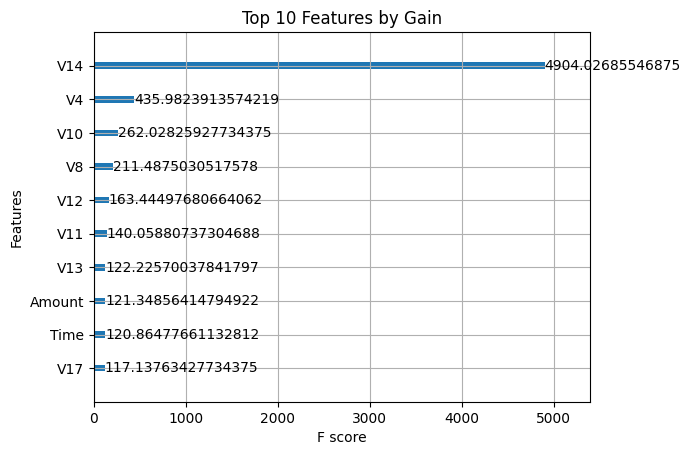

In [27]:
from xgboost import plot_importance
plt.figure(figsize=(10, 8))
plot_importance(best_xgb_model, importance_type='gain', max_num_features=10, title='Top 10 Features by Gain')
plt.show()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


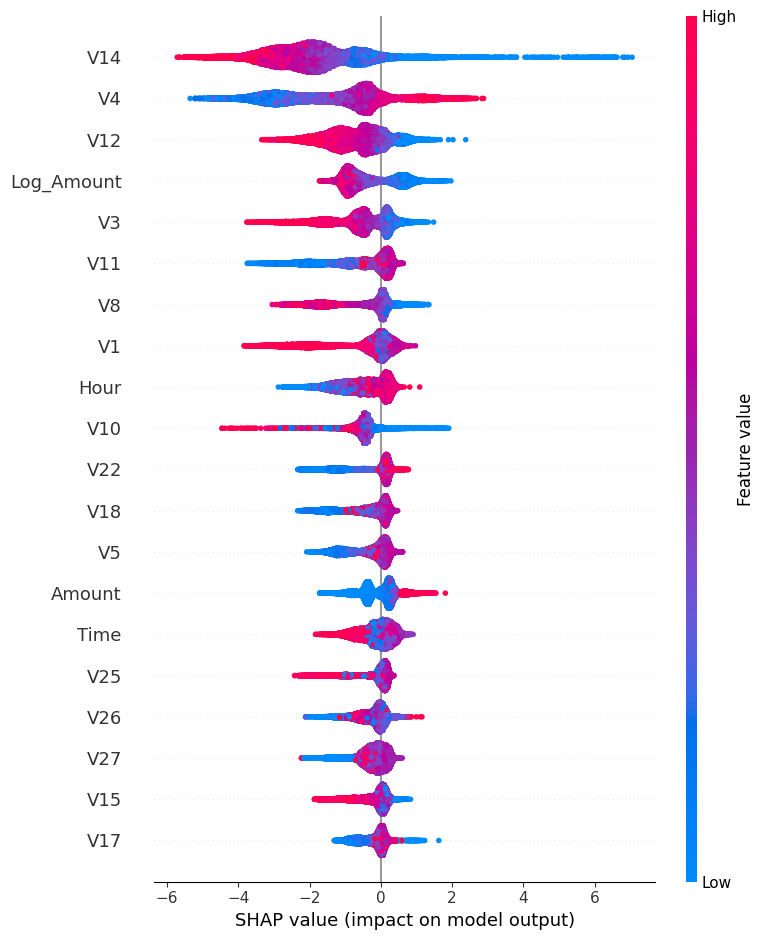

In [ ]:
import shap

explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test)

plt.figure()
shap.summary_plot(shap_values, X_test)

### Investigating the "Blind Spots" (False Negatives)

This section summarizes the comparative analysis between the fraud cases successfully caught by the XGBoost model (**True Positives**) and the ones it missed (**False Negatives**).

#### Statistical Comparison of Key Indicators
The model's failure to detect specific fraudulent transactions is directly linked to the "signal strength" of the behavioral features.

| Feature | Missed Fraud (FN) Mean | Detected Fraud (TP) Mean | Interpretation |
| :--- | :--- | :--- | :--- |
| **V14** | **-0.66** | **-7.95** | Missed cases lack the extreme negative deviation that triggers the model. |
| **V12** | -0.34 | -7.03 | The structural anomaly is ~20x weaker in missed cases. |
| **V4** | 1.22 | 3.12 | The "risk signature" is significantly muted in False Negatives. |
| **Amount** | **2.61** | 1.67 | Missed frauds actually have higher transaction values on average. |

#### Why the Model Misses These Cases
* **The "Stealth" Factor**: Our primary detection signals ($V14, V12$) are nearly 10 times weaker in the False Negative group. These transactions mimic "legitimate" behavior almost perfectly, falling within one standard deviation of the normal class mean.
* **The Amount Paradox**: The model is not biased toward large transactions. In fact, it caught lower-value frauds because they exhibited stranger behaviors ($V14$). It missed higher-value frauds because their behavioral markers appeared

In [ ]:
best_xgb_pipeline = xgb_grid.best_estimator_
y_pred_xgb = best_xgb_pipeline.predict(X_test)

false_negatives_mask = (y_test == 1) & (y_pred_xgb == 0)

fn_df = X_test[false_negatives_mask].copy()

print(f"Total False Negatives: {len(fn_df)}")
display(fn_df.head(18))

detected_fraud_mask = (y_test == 1) & (y_pred_xgb == 1)
df_detected = X_test[detected_fraud_mask]

print("\n--- Mean values for Missed Fraud (FN) ---")
print(fn_df[['Amount', 'V14', 'V12', 'V4']].mean())

print("\n--- Mean values for Detected Fraud (TP) ---")
print(df_detected[['Amount', 'V14', 'V12', 'V4']].mean())

Total False Negatives: 18


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Log_Amount,Hour,Amount_per_Time
1784,0.773287,0.821008,0.718007,-1.020568,2.918425,0.632758,-0.107814,-0.072868,0.126489,-0.133132,...,0.124722,-0.640931,0.062537,0.353485,0.252082,0.223390,-0.292032,-0.986346,0.222222,-0.272373
4480,0.818120,-0.046311,-2.855818,-1.459152,0.116719,-1.034896,-0.458262,1.300750,-0.922110,1.267813,...,-2.940226,0.088920,-0.131558,-1.893585,-1.065351,0.876727,14.949103,1.561187,0.333333,6.762399
5187,-0.371551,0.571611,0.252390,0.007305,0.581144,0.141315,-0.082745,0.104424,-0.420118,-0.021703,...,-0.355025,-0.606239,0.980706,-0.637268,0.193757,0.071037,-0.289529,-0.951543,-0.111111,-0.256934
10087,0.029491,-0.197222,-0.871001,-1.185656,1.766909,0.606556,0.092532,1.388416,-0.260648,-0.600193,...,4.187417,0.598238,-0.926763,-0.445928,-0.141130,0.898658,5.969545,1.202987,-1.666667,4.846739
12142,-0.373220,0.455307,0.245093,0.301435,2.002835,-0.395266,0.409452,-0.650645,0.728641,0.313954,...,-0.392337,0.389345,0.735495,0.426423,0.367856,0.395545,-0.295369,-1.037972,-0.111111,-0.264734
22495,-0.460571,0.439785,-0.011431,-0.275985,0.953720,0.184637,0.399832,-0.037375,0.234303,0.510411,...,-0.378956,-1.243097,0.658251,-0.707261,0.278954,0.407423,1.167988,0.620817,-0.333333,2.028228
27361,-0.424940,0.548142,0.328842,-0.375055,0.774600,0.409359,0.066682,0.007397,0.029734,0.145714,...,-0.587128,-1.206771,0.996291,-0.250866,0.274568,0.220059,-0.292032,-0.986346,-0.222222,-0.258547
29007,-0.350751,-1.347143,-0.046295,0.222224,0.226815,0.567503,-1.120914,0.412604,-0.477615,0.555850,...,4.282011,0.395432,0.646968,0.433246,7.495315,-0.192308,-0.281046,-0.851906,0.000000,-0.246629
30416,-0.162933,0.078997,0.803802,0.273875,1.832727,0.076052,1.304570,-1.103822,-4.571314,-0.951052,...,0.018208,-1.077477,0.575686,0.596893,0.826303,1.876721,-0.295369,-1.037972,0.444444,-0.268327
32358,0.732203,-0.933963,1.831918,-0.484373,0.451156,0.362234,1.430481,-1.548252,-11.888831,1.432659,...,1.522110,-1.375865,0.288706,-0.472092,0.086224,-0.468397,-0.194688,-0.378922,0.111111,-0.225050



--- Mean values for Missed Fraud (FN) ---
Amount    2.616535
V14      -0.665104
V12      -0.343177
V4        1.222440
dtype: float64

--- Mean values for Detected Fraud (TP) ---
Amount    1.677696
V14      -7.956525
V12      -7.039953
V4        3.123058
dtype: float64


### Model Interpretability (XAI)
To move beyond "black-box" predictions, we performed an in-depth analysis of the XGBoost model using **Gain-based Importance** and **SHAP (Shapley Additive Explanations)**.

#### Key Interpretability Findings:
* **Feature Dominance:** Feature **$V14$** was identified as the most critical predictor, possessing a "Gain" value significantly higher than all other variables.
* **Directional Logic:** SHAP analysis revealed a clear directional strategy:
    * **$V14$ & $V12$:** Low values are highly indicative of fraud.
    * **$V4$:** High values act as a secondary "trigger" for fraud detection.
* **Latent Signatures:** The model ignores the raw 'Amount' in favor of these latent behavioral signatures, proving that fraud is better identified by *how* a transaction occurs rather than just its *size*.